# 1. Постановка проблемы и задачи 

**Цель проекта:**
Прогнозирование цен на финансовые инструменты для краткосрочных сделок.

**Входные данные:**
Японские свечи по инструменту (открытие, закрытие, максимум, минимум) за последние 3 месяца по периодам:
1 минута
5 минут
15 минут
30 минут
 1 час
 
**Выходные данные:**
1.  Прогноз по параметрам японских свечи на каждый период (открытие, закрытие, максимум, минимум)
2.  3х классовая классификация цены на каждый период (увеличится, уменьшится, не изменится)

**Выходные данные для бизнеса:**
1.  При выставлении заявки на покупку/продажу инструмента рекомендовать цену ниже или выше рынка.
2.  Отображать в приложении прогнозные свечи по периодам.

**Метрики:** Поскольку цена ошибки классификации равноценна для неверных прогнозов о повышении, изменении, снижении (в любом случае потеря денег), взвешивание классов в функции потерь не требуется и в качестве основной метрики используем Macroaveraged F1-score как обобщённую ошибку.

In [1]:
# Расчёт технических индикаторов
import talib
from talib import abstract

# Алгебраические операции
import numpy as np
import pandas as pd
import scipy.stats

# Отрисовка графиков
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

# Предобработка данных
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# 2. Feature engeneering и подготовка данных к анализу 

In [2]:
# Класс, реализующий отбор n предикторов на основе ковариации с таргетом

class FeatureSelector:
    def __init__(self, num_features):
        self.n = num_features # number of best features to select

    def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
        X = X.values
        covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
        self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

    def transform(self, X):
        return pd.DataFrame(X.values[:,self.best_feature_ids], columns = list(X.iloc[:,self.best_feature_ids].columns))

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)


In [51]:
# Преобразование в датафрейм и разметка "классов" движения индекса RTS

periods = ['SPFB.RTS_211001_220301 1m',
           'SPFB.RTS_211001_220301 5m',
           'SPFB.RTS_211001_220301 10m',
           'SPFB.RTS_211001_220301 15m',
           'SPFB.RTS_211001_220301 30m',
           'SPFB.RTS_211001_220301 60m']
i = 0

for period in periods:
    periods[i] = pd.read_csv('{}.csv'.format(period), sep = ';')
    periods[i].rename(columns = {'<OPEN>':'open',
                                 '<HIGH>':'high',
                                 '<LOW>':'low',
                                 '<CLOSE>':'close',
                                 '<VOL>':'volume'}, inplace = True)
    periods[i]['Difference_close'] = periods[i]['close'].diff()
    periods[i] = periods[i].dropna()
    i += 1
    
periods[0]['Target'] = 1
periods[0]['Target'][periods[0]['Difference_close'] < -20] = 'Down'
periods[0]['Target'][periods[0]['Difference_close'] > 20] = 'Up'
periods[0]['Target'][(periods[0]['Difference_close'] <= 20) & (periods[0]['Difference_close'] >= -20)] = 'Stable'

periods[1]['Target'] = 1
periods[1]['Target'][periods[1]['Difference_close'] < -40] = 'Down'
periods[1]['Target'][periods[1]['Difference_close'] > 40] = 'Up'
periods[1]['Target'][(periods[1]['Difference_close'] <= 40) & (periods[1]['Difference_close'] >= -40)] = 'Stable'

periods[2]['Target'] = 1
periods[2]['Target'][periods[2]['Difference_close'] < -80] = 'Down'
periods[2]['Target'][periods[2]['Difference_close'] > 80] = 'Up'
periods[2]['Target'][(periods[2]['Difference_close'] <= 80) & (periods[2]['Difference_close'] >= -80)] = 'Stable'

periods[3]['Target'] = 1
periods[3]['Target'][periods[3]['Difference_close'] < -100] = 'Down'
periods[3]['Target'][periods[3]['Difference_close'] > 100] = 'Up'
periods[3]['Target'][(periods[3]['Difference_close'] <= 100) & (periods[3]['Difference_close'] >= -100)] = 'Stable'


periods[4]['Target'] = 1
periods[4]['Target'][periods[4]['Difference_close'] < -150] = 'Down'
periods[4]['Target'][periods[4]['Difference_close'] > 150] = 'Up'
periods[4]['Target'][(periods[4]['Difference_close'] <= 150) & (periods[4]['Difference_close'] >= -150)] = 'Stable'


periods[5]['Target'] = 1
periods[5]['Target'][periods[5]['Difference_close'] < -200] = 'Down'
periods[5]['Target'][periods[5]['Difference_close'] > 200] = 'Up'
periods[5]['Target'][(periods[5]['Difference_close'] <= 200) & (periods[5]['Difference_close'] >= -200)] = 'Stable'

In [52]:
# Конструирование признаков в виде технических индикаторов 
# с использованием средств библиотеки talib с разной величиной
# временного лага

# Переменные группы "Price transformations"

i = 0

for c in range(len(periods)):
    for j in range(10):
        periods[i]['AVGPRICE_lag{}'.format(j+1)] = abstract.AVGPRICE(periods[i]).shift(j+1)
        periods[i]['MEDPRICE_lag{}'.format(j+1)] = abstract.MEDPRICE(periods[i]).shift(j+1)
        periods[i]['TYPPRICE_lag{}'.format(j+1)] = abstract.TYPPRICE(periods[i]).shift(j+1)
        periods[i]['WCLPRICE_lag{}'.format(j+1)] = abstract.WCLPRICE(periods[i]).shift(j+1)
    i += 1

# Переменные группы "Statistic functions"

i = 0

for c in range(len(periods)):
    for j in range(10):
        periods[i]['BETA_lag{}'.format(j+1)] = abstract.BETA(periods[i]).shift(j+1)
        periods[i]['CORREL_lag{}'.format(j+1)] = abstract.CORREL(periods[i]).shift(j+1)
        periods[i]['LINEARREG_lag{}'.format(j+1)] = abstract.LINEARREG(periods[i]).shift(j+1)
        periods[i]['LINEARREG_INTERCEPT_lag{}'.format(j+1)] = abstract.LINEARREG_INTERCEPT(periods[i]).shift(j+1)
        periods[i]['LINEARREG_SLOPE_lag{}'.format(j+1)] = abstract.LINEARREG_SLOPE(periods[i]).shift(j+1)
        periods[i]['STDDEV_lag{}'.format(j+1)] = abstract.STDDEV(periods[i]).shift(j+1)
        periods[i]['TSF_lag{}'.format(j+1)] = abstract.TSF(periods[i]).shift(j+1)
        periods[i]['VAR_lag{}'.format(j+1)] = abstract.VAR(periods[i]).shift(j+1)
    i += 1
    
# Переменные группы "Volatility"

i = 0

for c in range(len(periods)):
    for j in range(10):
        periods[i]['ATR_lag{}'.format(j+1)] = abstract.ATR(periods[i]).shift(j+1)
        periods[i]['NATR_lag{}'.format(j+1)] = abstract.NATR(periods[i]).shift(j+1)
        periods[i]['TRANGE_lag{}'.format(j+1)] = abstract.TRANGE(periods[i]).shift(j+1)
    i += 1
    
# Переменные группы "Volume"

i = 0

for c in range(len(periods)):
    for j in range(10):
        periods[i]['AD_lag{}'.format(j+1)] = abstract.AD(periods[i]).shift(j+1)
        periods[i]['ADOSC_lag{}'.format(j+1)] = abstract.ADOSC(periods[i]).shift(j+1)
        periods[i]['OBV_lag{}'.format(j+1)] = abstract.OBV(periods[i]).shift(j+1)
    i += 1
    
# Переменные группы "Сycle"

i = 0

for c in range(len(periods)):
    for j in range(10):
        periods[i]['HT_DCPERIOD_lag{}'.format(j+1)] = abstract.HT_DCPERIOD(periods[i]).shift(j+1)
        periods[i]['HT_DCPHASE_lag{}'.format(j+1)] = abstract.HT_DCPHASE(periods[i]).shift(j+1)
        periods[i]['HT_TRENDMODE_lag{}'.format(j+1)] = abstract.HT_TRENDMODE(periods[i]).shift(j+1)
    i += 1
    
# Переменные группы "Momentum Indicators"

i = 0

for c in range(len(periods)):
    for j in range(10):
        periods[i]['ADX_lag{}'.format(j+1)] = abstract.ADX(periods[i]).shift(j+1)
        periods[i]['ADXR_lag{}'.format(j+1)] = abstract.ADXR(periods[i]).shift(j+1)
        periods[i]['APO_lag{}'.format(j+1)] = abstract.APO(periods[i]).shift(j+1)
        periods[i]['AROONOSC_lag{}'.format(j+1)] = abstract.AROONOSC(periods[i]).shift(j+1)
        periods[i]['BOP_lag{}'.format(j+1)] = abstract.BOP(periods[i]).shift(j+1)
        periods[i]['CCI_lag{}'.format(j+1)] = abstract.CCI(periods[i]).shift(j+1)
        periods[i]['CMO_lag{}'.format(j+1)] = abstract.CMO(periods[i]).shift(j+1)
        periods[i]['DX_lag{}'.format(j+1)] = abstract.DX(periods[i]).shift(j+1)
        periods[i]['MFI_lag{}'.format(j+1)] = abstract.MFI(periods[i]).shift(j+1)
        periods[i]['MINUS_DI_lag{}'.format(j+1)] = abstract.MINUS_DI(periods[i]).shift(j+1)
        periods[i]['MINUS_DM_lag{}'.format(j+1)] = abstract.MINUS_DM(periods[i]).shift(j+1)
        periods[i]['MOM_lag{}'.format(j+1)] = abstract.MOM(periods[i]).shift(j+1)
        periods[i]['PLUS_DI_lag{}'.format(j+1)] = abstract.PLUS_DI(periods[i]).shift(j+1)
        periods[i]['PLUS_DM_lag{}'.format(j+1)] = abstract.PLUS_DM(periods[i]).shift(j+1)
        periods[i]['PPO_lag{}'.format(j+1)] = abstract.PPO(periods[i]).shift(j+1)
        periods[i]['ROC_lag{}'.format(j+1)] = abstract.ROC(periods[i]).shift(j+1)
        periods[i]['ROCP_lag{}'.format(j+1)] = abstract.ROCP(periods[i]).shift(j+1)
        periods[i]['ROCR_lag{}'.format(j+1)] = abstract.ROCR(periods[i]).shift(j+1)
        periods[i]['ROCR100_lag{}'.format(j+1)] = abstract.ROCR100(periods[i]).shift(j+1)
        periods[i]['RSI_lag{}'.format(j+1)] = abstract.RSI(periods[i]).shift(j+1)
        periods[i]['TRIX_lag{}'.format(j+1)] = abstract.TRIX(periods[i]).shift(j+1)
        periods[i]['ULTOSC_lag{}'.format(j+1)] = abstract.ULTOSC(periods[i]).shift(j+1)
        periods[i]['WILLR_lag{}'.format(j+1)] = abstract.WILLR(periods[i]).shift(j+1)
    i += 1
    
# Переменные группы "Pattern reckognition"

i = 0

for c in range(len(periods)):
    for j in range(10):
        periods[i]['CDL2CROWS_lag{}'.format(j+1)] = abstract.CDL2CROWS(periods[i]).shift(j+1)
        periods[i]['CDL3BLACKCROWS_lag{}'.format(j+1)] = abstract.CDL3BLACKCROWS(periods[i]).shift(j+1)
        periods[i]['CDL3INSIDE_lag{}'.format(j+1)] = abstract.CDL3INSIDE(periods[i]).shift(j+1)
        periods[i]['CDL3LINESTRIKE_lag{}'.format(j+1)] = abstract.CDL3LINESTRIKE(periods[i]).shift(j+1)
        periods[i]['CDL3OUTSIDE_lag{}'.format(j+1)] = abstract.CDL3OUTSIDE(periods[i]).shift(j+1)
        periods[i]['CDL3STARSINSOUTH_lag{}'.format(j+1)] = abstract.CDL3STARSINSOUTH(periods[i]).shift(j+1)
        periods[i]['CDL3WHITESOLDIERS_lag{}'.format(j+1)] = abstract.CDL3WHITESOLDIERS(periods[i]).shift(j+1)
        periods[i]['CDLABANDONEDBABY_lag{}'.format(j+1)] = abstract.CDLABANDONEDBABY(periods[i]).shift(j+1)
        periods[i]['CDLADVANCEBLOCK_lag{}'.format(j+1)] = abstract.CDLADVANCEBLOCK(periods[i]).shift(j+1)
        periods[i]['CDLBELTHOLD_lag{}'.format(j+1)] = abstract.CDLBELTHOLD(periods[i]).shift(j+1)
        periods[i]['CDLBREAKAWAY_lag{}'.format(j+1)] = abstract.CDLBREAKAWAY(periods[i]).shift(j+1)
        periods[i]['CDLCLOSINGMARUBOZU_lag{}'.format(j+1)] = abstract.CDLCLOSINGMARUBOZU(periods[i]).shift(j+1)
        periods[i]['CDLCONCEALBABYSWALL_lag{}'.format(j+1)] = abstract.CDLCONCEALBABYSWALL(periods[i]).shift(j+1)
        periods[i]['CDLCOUNTERATTACK_lag{}'.format(j+1)] = abstract.CDLCOUNTERATTACK(periods[i]).shift(j+1)
        periods[i]['CDLDARKCLOUDCOVER_lag{}'.format(j+1)] = abstract.CDLDARKCLOUDCOVER(periods[i]).shift(j+1)
        periods[i]['CDLDOJI_lag{}'.format(j+1)] = abstract.CDLDOJI(periods[i]).shift(j+1)
        periods[i]['CDLDOJISTAR_lag{}'.format(j+1)] = abstract.CDLDOJISTAR(periods[i]).shift(j+1)
        periods[i]['CDLDRAGONFLYDOJI_lag{}'.format(j+1)] = abstract.CDLDRAGONFLYDOJI(periods[i]).shift(j+1)
        periods[i]['CDLENGULFING_lag{}'.format(j+1)] = abstract.CDLENGULFING(periods[i]).shift(j+1)
        periods[i]['CDLEVENINGDOJISTAR_lag{}'.format(j+1)] = abstract.CDLEVENINGDOJISTAR(periods[i]).shift(j+1)
        periods[i]['CDLEVENINGSTAR_lag{}'.format(j+1)] = abstract.CDLEVENINGSTAR(periods[i]).shift(j+1)
        periods[i]['CDLGAPSIDESIDEWHITE_lag{}'.format(j+1)] = abstract.CDLGAPSIDESIDEWHITE(periods[i]).shift(j+1)
        periods[i]['CDLGRAVESTONEDOJI_lag{}'.format(j+1)] = abstract.CDLGRAVESTONEDOJI(periods[i]).shift(j+1)
        periods[i]['CDLHAMMER_lag{}'.format(j+1)] = abstract.CDLHAMMER(periods[i]).shift(j+1)
        periods[i]['CDLHANGINGMAN_lag{}'.format(j+1)] = abstract.CDLHANGINGMAN(periods[i]).shift(j+1)
        periods[i]['CDLHARAMI_lag{}'.format(j+1)] = abstract.CDLHARAMI(periods[i]).shift(j+1)
        periods[i]['CDLHARAMICROSS_lag{}'.format(j+1)] = abstract.CDLHARAMICROSS(periods[i]).shift(j+1)
        periods[i]['CDLHIGHWAVE_lag{}'.format(j+1)] = abstract.CDLHIGHWAVE(periods[i]).shift(j+1)
        periods[i]['CDLHIKKAKE_lag{}'.format(j+1)] = abstract.CDLHIKKAKE(periods[i]).shift(j+1)
        periods[i]['CDLHIKKAKEMOD_lag{}'.format(j+1)] = abstract.CDLHIKKAKEMOD(periods[i]).shift(j+1)
        periods[i]['CDLHOMINGPIGEON_lag{}'.format(j+1)] = abstract.CDLHOMINGPIGEON(periods[i]).shift(j+1)
        periods[i]['CDLIDENTICAL3CROWS_lag{}'.format(j+1)] = abstract.CDLIDENTICAL3CROWS(periods[i]).shift(j+1)
        periods[i]['CDLINNECK_lag{}'.format(j+1)] = abstract.CDLINNECK(periods[i]).shift(j+1)
        periods[i]['CDLINVERTEDHAMMER_lag{}'.format(j+1)] = abstract.CDLINVERTEDHAMMER(periods[i]).shift(j+1)
        periods[i]['CDLKICKING_lag{}'.format(j+1)] = abstract.CDLKICKING(periods[i]).shift(j+1)
        periods[i]['CDLLADDERBOTTOM_lag{}'.format(j+1)] = abstract.CDLLADDERBOTTOM(periods[i]).shift(j+1)
        periods[i]['CDLLONGLEGGEDDOJI_lag{}'.format(j+1)] = abstract.CDLLONGLEGGEDDOJI(periods[i]).shift(j+1)
        periods[i]['CDLLONGLINE_lag{}'.format(j+1)] = abstract.CDLLONGLINE(periods[i]).shift(j+1)
        periods[i]['CDLMARUBOZU_lag{}'.format(j+1)] = abstract.CDLMARUBOZU(periods[i]).shift(j+1)
        periods[i]['CDLMATCHINGLOW_lag{}'.format(j+1)] = abstract.CDLMATCHINGLOW(periods[i]).shift(j+1)
        periods[i]['CDLMATHOLD_lag{}'.format(j+1)] = abstract.CDLMATHOLD(periods[i]).shift(j+1)
        periods[i]['CDLMORNINGDOJISTAR_lag{}'.format(j+1)] = abstract.CDLMORNINGDOJISTAR(periods[i]).shift(j+1)
        periods[i]['CDLONNECK_lag{}'.format(j+1)] = abstract.CDLONNECK(periods[i]).shift(j+1)
        periods[i]['CDLPIERCING_lag{}'.format(j+1)] = abstract.CDLPIERCING(periods[i]).shift(j+1)
        periods[i]['CDLRICKSHAWMAN_lag{}'.format(j+1)] = abstract.CDLRICKSHAWMAN(periods[i]).shift(j+1)
        periods[i]['CDLRISEFALL3METHODS_lag{}'.format(j+1)] = abstract.CDLRISEFALL3METHODS(periods[i]).shift(j+1)
        periods[i]['CDLSEPARATINGLINES_lag{}'.format(j+1)] = abstract.CDLSEPARATINGLINES(periods[i]).shift(j+1)
        periods[i]['CDLRISEFALL3METHODS_lag{}'.format(j+1)] = abstract.CDLRISEFALL3METHODS(periods[i]).shift(j+1)
        periods[i]['CDLSHOOTINGSTAR_lag{}'.format(j+1)] = abstract.CDLSHOOTINGSTAR(periods[i]).shift(j+1)
        periods[i]['CDLSHORTLINE_lag{}'.format(j+1)] = abstract.CDLSHORTLINE(periods[i]).shift(j+1)
        periods[i]['CDLSPINNINGTOP_lag{}'.format(j+1)] = abstract.CDLSPINNINGTOP(periods[i]).shift(j+1)
        periods[i]['CDLSTALLEDPATTERN_lag{}'.format(j+1)] = abstract.CDLSTALLEDPATTERN(periods[i]).shift(j+1)
        periods[i]['CDLSTICKSANDWICH_lag{}'.format(j+1)] = abstract.CDLSTICKSANDWICH(periods[i]).shift(j+1)
        periods[i]['CDLTAKURI_lag{}'.format(j+1)] = abstract.CDLTAKURI(periods[i]).shift(j+1)
        periods[i]['CDLTASUKIGAP_lag{}'.format(j+1)] = abstract.CDLTASUKIGAP(periods[i]).shift(j+1)
        periods[i]['CDLTHRUSTING_lag{}'.format(j+1)] = abstract.CDLTHRUSTING(periods[i]).shift(j+1)
        periods[i]['CDLTRISTAR_lag{}'.format(j+1)] = abstract.CDLTRISTAR(periods[i]).shift(j+1)
        periods[i]['CDLUNIQUE3RIVER_lag{}'.format(j+1)] = abstract.CDLUNIQUE3RIVER(periods[i]).shift(j+1)
        periods[i]['CDLTRISTAR_lag{}'.format(j+1)] = abstract.CDLTRISTAR(periods[i]).shift(j+1)
        periods[i]['CDLTRISTAR_lag{}'.format(j+1)] = abstract.CDLTRISTAR(periods[i]).shift(j+1)
        periods[i]['CDLUPSIDEGAP2CROWS_lag{}'.format(j+1)] = abstract.CDLUPSIDEGAP2CROWS(periods[i]).shift(j+1)
        periods[i]['CDLXSIDEGAP3METHODS_lag{}'.format(j+1)] = abstract.CDLXSIDEGAP3METHODS(periods[i]).shift(j+1)
    i += 1

In [53]:
i = 0
for period in periods:
    periods[i] = periods[i].dropna()
    i += 1

In [54]:
X_1 = periods[0].iloc[:,11:]
X_2 = periods[1].iloc[:,11:]
X_3 = periods[2].iloc[:,11:]
X_4 = periods[3].iloc[:,11:]
X_5 = periods[4].iloc[:,11:]
X_6 = periods[5].iloc[:,11:]

y_1 = periods[0].loc[:,'Difference_close'].values
y_2 = periods[1].loc[:,'Difference_close'].values
y_3 = periods[2].loc[:,'Difference_close'].values
y_4 = periods[3].loc[:,'Difference_close'].values
y_5 = periods[4].loc[:,'Difference_close'].values
y_6 = periods[5].loc[:,'Difference_close'].values

In [55]:
# отбор признаков с наибольшей ковариацией с таргетом

features_0 = FeatureSelector(25).fit_transform(X_1, y_1)
features_1 = FeatureSelector(35).fit_transform(X_2, y_2)
features_2 = FeatureSelector(35).fit_transform(X_3, y_3)
features_3 = FeatureSelector(35).fit_transform(X_4, y_4)
features_4 = FeatureSelector(35).fit_transform(X_5, y_5)
features_5 = FeatureSelector(35).fit_transform(X_6, y_6)

features_0.index = periods[0].index
features_1.index = periods[1].index
features_2.index = periods[2].index
features_3.index = periods[3].index
features_4.index = periods[4].index
features_5.index = periods[5].index

In [56]:
features_0['Difference_close'] = periods[0]['Difference_close']
features_1['Difference_close'] = periods[1]['Difference_close']
features_2['Difference_close'] = periods[2]['Difference_close']
features_3['Difference_close'] = periods[3]['Difference_close']
features_4['Difference_close'] = periods[4]['Difference_close']
features_5['Difference_close'] = periods[5]['Difference_close']

features_0['Target'] = periods[0]['Target']
features_1['Target'] = periods[1]['Target']
features_2['Target'] = periods[2]['Target']
features_3['Target'] = periods[3]['Target']
features_4['Target'] = periods[4]['Target']
features_5['Target'] = periods[5]['Target']

In [10]:
# балансировка классов

def split_balance(data, target):
    # Split to train and test before balancing
    train_data, test_data = train_test_split(data, random_state=24)

    # Split train to train and validation datasetsбю.
        train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=24)

    #Balance by subspecies to train_data_bal_ss dataset
    # Number of samples in each category
    ncat_bal = int(len(train_data)/len(train_data[target].unique()))
    train_data_bal = train_data.groupby(target, as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True)).reset_index(drop=True)
    return(train_data_bal, val_data, test_data)

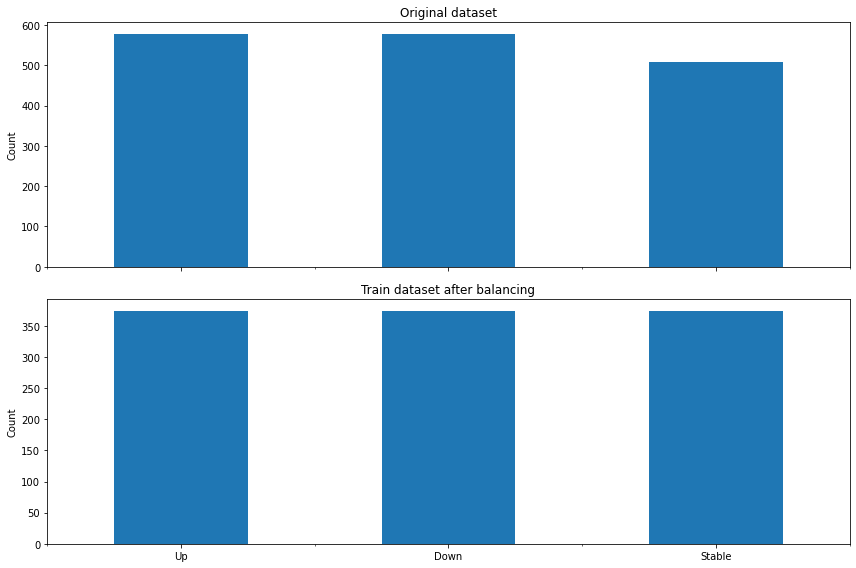

In [16]:
train_data_bal, val_data, test_data = split_balance(features_5, 'Target')

f, axs = plt.subplots(2,1, figsize=(12,8), sharex = True)

# Oridigan data
ax = features_5['Target'].value_counts().plot(kind='bar', rot = 0, ax=axs[0])
ax.set_title('Original dataset')
ax.set_ylabel('Count')

# Balanced train
ax = train_data_bal['Target'].value_counts().plot(kind='bar', rot = 0, ax=axs[1])
ax.set_title('Train dataset after balancing')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

# 3. Построение модели

In [18]:
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import fbeta_score, make_scorer
from skopt import gp_minimize

# Байесовская оптимизация гиперпараметров числа скрытых слоёв
# и фиксированного числа нейронов на слой
# для многослойного перцептрона

clf = MLPClassifier(max_iter = 100000, random_state=0)

space=[
    Categorical(['tanh','relu'],name='activation'),
    Integer(6,20,name='n_hidden_layer'),
    Integer(50,100,name='n_neurons_per_layer')]

@use_named_args(space)

def objective(**params):
    n_neurons=params['n_neurons_per_layer']
    n_layers=params['n_hidden_layer']

    # create the hidden layers as a tuple with length n_layers and n_neurons per layer
    params['hidden_layer_sizes']=(n_neurons,)*n_layers

    # the parameters are deleted to avoid an error from the MLPRegressor
    params.pop('n_neurons_per_layer')
    params.pop('n_hidden_layer')
    
    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, train_data_bal.drop(['Target', 'Difference_close'], axis = 1), train_data_bal['Target'], cv=5, n_jobs=-1,
                                   scoring=make_scorer(f1_score, average='macro')))

clf_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

In [163]:
clf_gp

          fun: -0.6140077129229573
    func_vals: array([-0.45746776, -0.44642779, -0.53648877, -0.422899  , -0.54813375,
       -0.47300098, -0.57978118, -0.47217263, -0.45486707, -0.47626041,
       -0.58115199, -0.51012862, -0.43787949, -0.48685096, -0.4487776 ,
       -0.44599483, -0.44788332, -0.54151143, -0.53343853, -0.50301881,
       -0.55630007, -0.44351801, -0.51012862, -0.37989351, -0.58754717,
       -0.61400771, -0.58579339, -0.61400771, -0.61400771, -0.61400771,
       -0.61400771, -0.61400771, -0.58754717, -0.58579339, -0.58579339,
       -0.58754717, -0.45567727, -0.4277306 , -0.45627924, -0.45569316,
       -0.58754717, -0.485238  , -0.47515114, -0.485238  , -0.61400771,
       -0.61400771, -0.58727373, -0.45627924, -0.61400771, -0.58754717])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=T

In [164]:
# Байесовская оптимизация гиперпараметров
# числа нейронов на каждый слой
# для многослойного перцептрона

clf = MLPClassifier(max_iter = 1000000, random_state=0, activation = 'tanh')

space=[
    Integer(60,100 ,name='n_neurons_per_layer1'),
    Integer(60,100,name='n_neurons_per_layer2'),
    Integer(60,100,name='n_neurons_per_layer3'),
    Integer(60,100,name='n_neurons_per_layer4'),
    Integer(60,100,name='n_neurons_per_layer5'),
    Integer(60,100,name='n_neurons_per_layer6'),
    Integer(60,100,name='n_neurons_per_layer7'),
    Integer(60,100 ,name='n_neurons_per_layer8'),
    Integer(60,100,name='n_neurons_per_layer9'),
    Integer(60,100,name='n_neurons_per_layer10'),
    Integer(60,100,name='n_neurons_per_layer11'),
    Integer(60,100,name='n_neurons_per_layer12'),
    Integer(60,100,name='n_neurons_per_layer13'),
    Integer(60,100,name='n_neurons_per_layer14'),
    Integer(60,100,name='n_neurons_per_layer15'),
    Integer(60,100,name='n_neurons_per_layer16'),
    Integer(60,100,name='n_neurons_per_layer17')
]


@use_named_args(space)

def objective(**params):
    n_neurons1=params['n_neurons_per_layer1']
    n_neurons2=params['n_neurons_per_layer2']
    n_neurons3=params['n_neurons_per_layer3']
    n_neurons4=params['n_neurons_per_layer4']
    n_neurons5=params['n_neurons_per_layer5']
    n_neurons6=params['n_neurons_per_layer6']
    n_neurons7=params['n_neurons_per_layer7']
    n_neurons8=params['n_neurons_per_layer8']
    n_neurons9=params['n_neurons_per_layer9']
    n_neurons10=params['n_neurons_per_layer10']
    n_neurons11=params['n_neurons_per_layer11']
    n_neurons12=params['n_neurons_per_layer12']
    n_neurons13=params['n_neurons_per_layer13']
    n_neurons14=params['n_neurons_per_layer14']
    n_neurons15=params['n_neurons_per_layer15']
    n_neurons16=params['n_neurons_per_layer16']
    n_neurons17=params['n_neurons_per_layer17']


    # create the hidden layers as a tuple with length n_layers and n_neurons per layer
    params['hidden_layer_sizes']=(n_neurons1, n_neurons2, n_neurons3, n_neurons4, n_neurons5,
                                  n_neurons6, n_neurons7,n_neurons8,n_neurons9,n_neurons10, n_neurons11,
                                 n_neurons12,n_neurons13,n_neurons14, n_neurons15, n_neurons16, n_neurons17)

    # the parameters are deleted to avoid an error from the MLPRegressor
    params.pop('n_neurons_per_layer1')
    params.pop('n_neurons_per_layer2')
    params.pop('n_neurons_per_layer3')
    params.pop('n_neurons_per_layer4')
    params.pop('n_neurons_per_layer5')
    params.pop('n_neurons_per_layer6')
    params.pop('n_neurons_per_layer7')
    params.pop('n_neurons_per_layer8')
    params.pop('n_neurons_per_layer9')
    params.pop('n_neurons_per_layer10')
    params.pop('n_neurons_per_layer11')
    params.pop('n_neurons_per_layer12')
    params.pop('n_neurons_per_layer13')
    params.pop('n_neurons_per_layer14')
    params.pop('n_neurons_per_layer15')
    params.pop('n_neurons_per_layer16')
    params.pop('n_neurons_per_layer17')



    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, train_data_bal.drop(['Target', 'Difference_close'], axis = 1), train_data_bal['Target'], cv=5, n_jobs=-1,
                                   scoring=make_scorer(f1_score, average='macro')))

clf_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

In [165]:
clf_gp

          fun: -0.5932656465504608
    func_vals: array([-0.4633289 , -0.56354428, -0.49818716, -0.51865542, -0.51188502,
       -0.59326565, -0.51085995, -0.54155082, -0.45507919, -0.51214993,
       -0.56216419, -0.41428687, -0.41525787, -0.57007537, -0.49925923,
       -0.45940502, -0.45983575, -0.52554289, -0.57347579, -0.45259457,
       -0.49571331, -0.44948623, -0.4859848 , -0.46201921, -0.4928632 ,
       -0.44411822, -0.45286028, -0.46850823, -0.45426738, -0.44412577,
       -0.51735681, -0.53281162, -0.50220569, -0.50984484, -0.44346452,
       -0.54925424, -0.55000663, -0.56572313, -0.55181852, -0.51526388,
       -0.55263296, -0.52012645, -0.48620607, -0.42117323, -0.50301115,
       -0.53223246, -0.50266261, -0.47618045, -0.50538087, -0.56337149])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
              

In [177]:
model = MLPClassifier(activation = 'tanh',hidden_layer_sizes = (64, 54, 74, 75, 58, 49, 62, 73) 
                      , max_iter = 10000000,
                      random_state=0)

# Стандартизация исходных переменных

data = StandardScaler().fit_transform(train_data_bal.loc[:, list(features_5.drop(['Target','Difference_close'], axis = 1).columns)].values)

data = pd.DataFrame(data = data, columns = list(features_5.drop(['Target','Difference_close'], axis = 1).columns))
data.index = train_data_bal.index
data = pd.concat([data, train_data_bal['Target']], axis = 1)
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

# Обучение модели

model.fit(
    feature_selection_and_preprocessing(
        data_train.loc[:, list(features_5.drop(['Target','Difference_close'], axis = 1).columns)]
    ),
    data_train['Target']
)

train_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_train.loc[:, list(features_5.drop(['Target','Difference_close'], axis = 1).columns)]
    )
)

test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Target', axis=1)
    )
)

print("Train F1-score:", f1_score(
    data_train['Target'],
    train_predictions,
    average = 'macro'
))
print("Test F1-score:", f1_score(
    data_test['Target'],
    test_predictions,
    average = 'macro'
))
print()
print('Выводим confusion_matrix')

confusion_matrix(data_test['Target'], test_predictions)

Train F1-score: 0.9855573745149456
Test F1-score: 0.7420597509217673

Выводим confusion_matrix


array([[44, 14, 17],
       [ 5, 64,  5],
       [ 9,  7, 60]], dtype=int64)

In [178]:
from joblib import dump
dump(model, 'RTS_NN_60min.joblib')

['RTS_NN_60min.joblib']